# Disentangled RNN Analysis
In this notebook, you can see how the latent variables are maintained inside the disentangled RNN. You can also see the validation and training loss over training.

In [1]:
from src import disrnn
from src import switch_utils
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import jax
import jax.numpy as jnp
import haiku as hk

In [29]:
data_dir = '/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/data/processed'
model_dir = "/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/models/"

# choose mouse, beta and run time
model_name = 'disrnn'
train_prop = 0.7
param = 0.03
cv = f'{train_prop*100:.0f}-{(1-train_prop)*100:.0f}'
train_dt = "2025-04-20_00-01"
split_dt = "2025-04-17_10-28"
batch_size = 64

model_shape = {'dis_latent_size': 5,
                'tiny_latent_size': 2,
                'update_mlp_shape': (5,5,5),
                'choice_mlp_shape': (2,2),
                'obs_size': 2,
                'target_size': 2}

param_dict = {'disrnn': f'{param:.0e}', 'rnn': f'{param}'}
params_file = os.path.join(model_dir, f"params_{model_name}_{param_dict[model_name]}_{cv}_{train_dt}.json")
loss_file = os.path.join(model_dir, f"loss_{model_name}_{param_dict[model_name]}_{cv}_{train_dt}.csv")

df_tr = pd.read_csv(os.path.join(data_dir, f"train_df_{cv}_{split_dt}.csv"))
df_va = pd.read_csv(os.path.join(data_dir, f"validation_df_{cv}_{split_dt}.csv"))

params, losses = switch_utils.model_loader(params_file=params_file, loss_file=loss_file)

ds_tr = switch_utils.get_dataset(df_tr, batch_size)
ds_va = switch_utils.get_dataset(df_va, batch_size)


def make_network_eval():
    return disrnn.HkDisRNN(update_mlp_shape=model_shape['update_mlp_shape'],
                            choice_mlp_shape=model_shape['choice_mlp_shape'],
                            latent_size=model_shape['dis_latent_size'],
                            obs_size=model_shape['obs_size'], 
                            target_size=model_shape['target_size'],
                            eval_mode=True)




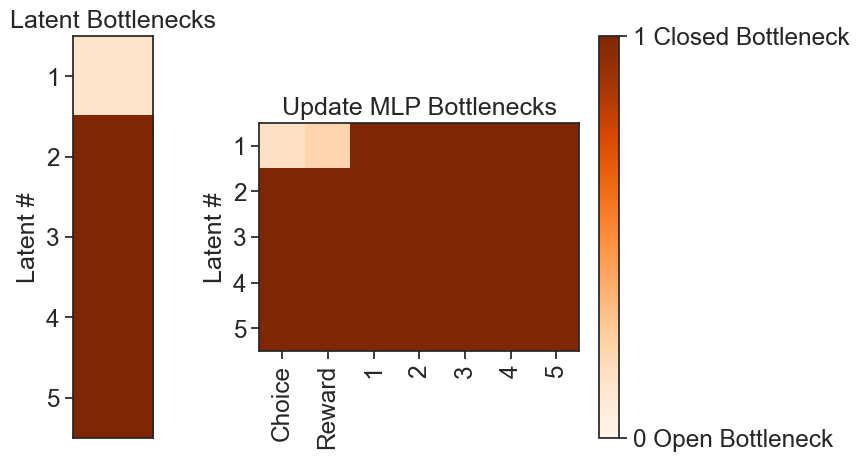

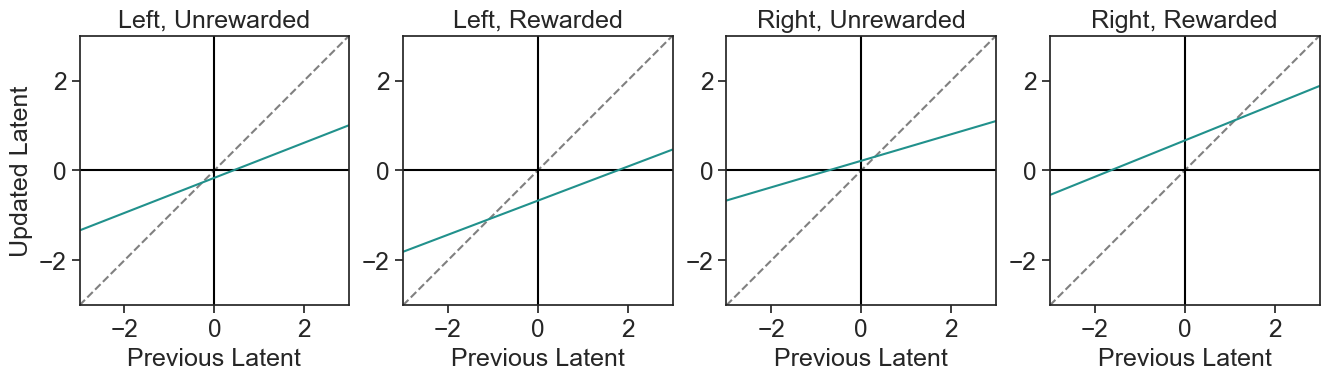

In [30]:
disrnn.plot_bottlenecks(params, sort_latents=True)
plt.show()
disrnn.plot_update_rules(params, make_network_eval)
plt.show()

## Training and validation loss.

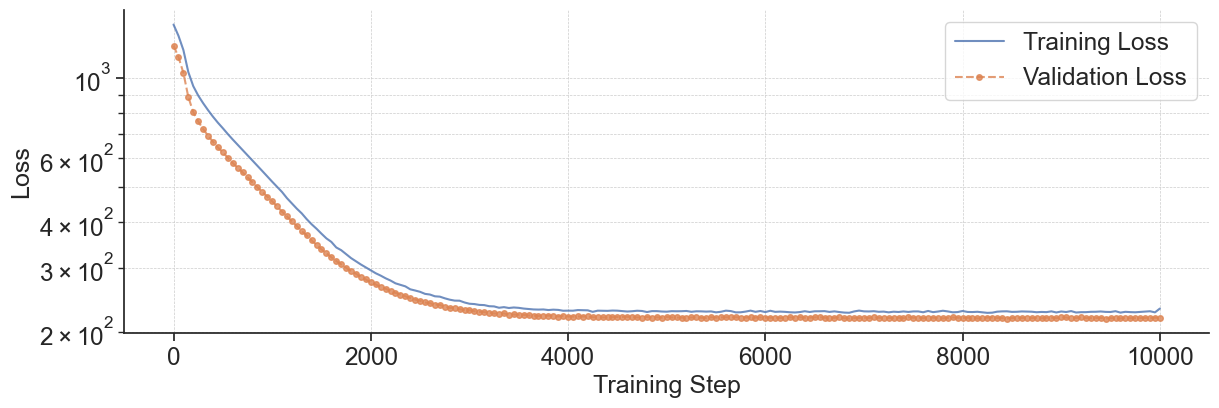

In [31]:
plt.figure(figsize=(14, 4.2))
sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 
plt.semilogy(losses.index*50, losses['training_loss'], label='Training Loss', alpha=0.8, color=sns.color_palette()[0])
plt.semilogy(losses.index*50, losses['validation_loss'], label='Validation Loss', linestyle='--', marker='o', markersize=4, alpha=0.8, color=sns.color_palette()[1])
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.show()

In [32]:
def unroll_network(xs):
  core = make_network_eval()
  batch_size = jnp.shape(xs)[1]
  state = core.initial_state(batch_size)
  ys, _ = hk.dynamic_unroll(core, xs, state)
  return ys


_, step_hk = hk.transform(unroll_network)
step_hk = jax.jit(step_hk)

random_key = jax.random.PRNGKey(0)

# first two columns give the probability of left and right (but need to be put through
# softmax for normalising)
output = step_hk(params, random_key, ds_va._xs)[:,:,:2]
# sample from the output either greedily or with thompson sampling
sample_type = 'thompson'
y_sampled = switch_utils.sampler(output, sample_type)
ll = switch_utils.log_likelihood_normalised(ds_va._ys, output)
parameter_arrays = jax.tree_util.tree_leaves(params)
total_params = jnp.sum(jnp.array([arr.size for arr in parameter_arrays]))
print(f"The log likelihood for {model_name} is {ll:.3f}.")
print(f"The total number of parameters in the network is: {total_params}")

The log likelihood for disrnn is -0.202.
The total number of parameters in the network is: 664


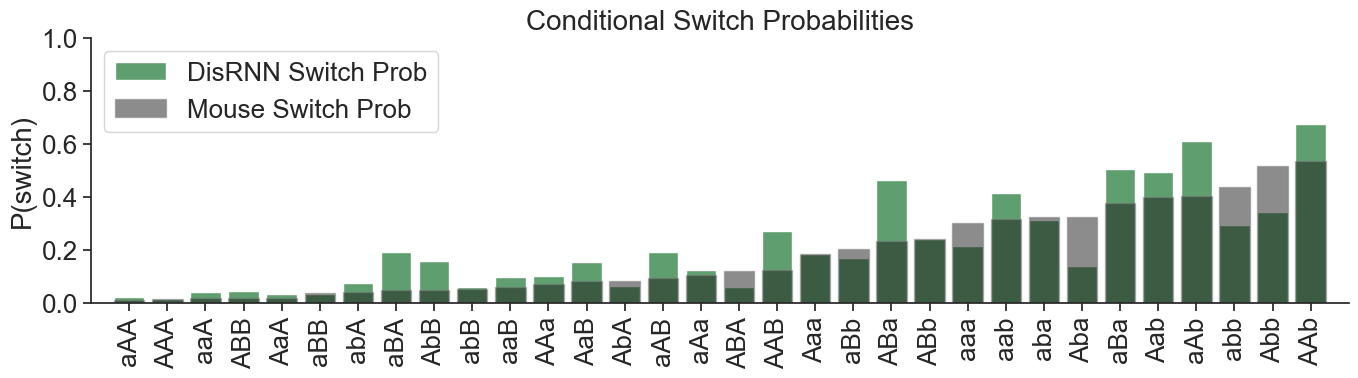

In [33]:
# simulated conditional probability dictionary for each 3 letter history
p_dict = switch_utils.switch_bars(ds_va._xs, ds_va._xs[:,:,0], symm=True, prob=True)
sim_p_dict = switch_utils.switch_bars(ds_va._xs[1:], y_sampled[:-1], symm=True, prob=True)

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_keys = [item[0] for item in sorted_items] 
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
sim_sorted_heights = [sim_p_dict[key] for key in sorted_keys]

sns.set_theme(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sim_sorted_heights, color=sns.color_palette()[2], alpha=1, ax=ax, label='DisRNN Switch Prob')
sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray', label='Mouse Switch Prob')

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.title('Conditional Switch Probabilities')
plt.tight_layout()
plt.legend()
# plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/switch_probs.pdf') 
plt.show()

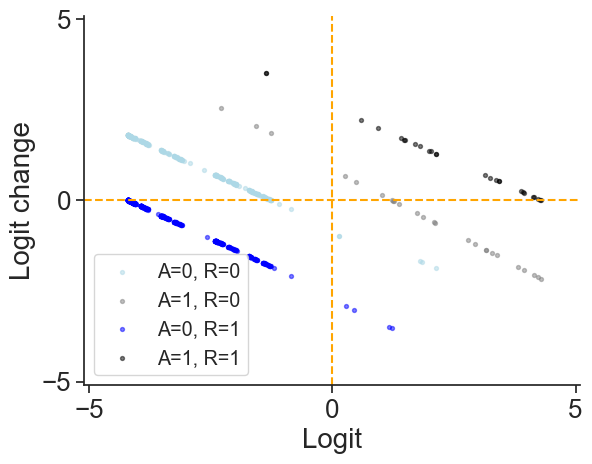

In [34]:
import numpy as np

logits = -jax.nn.log_softmax(output, axis=2)[:,:,0] + jax.nn.log_softmax(output, axis=2)[:,:,1]
logits_change = jnp.diff(logits, axis=0)


sess = (150)
logits=logits[:-1]
logits_ma = np.ma.masked_where(ds_va._xs[:-1,:,0]==-1, logits)
logits_change_ma = np.ma.masked_where(ds_va._xs[:-1,:,0]==-1, logits_change)

ac_re_arr = ds_va._xs[:,:,0] + 2* ds_va._xs[:,:,1]
ac_re_mask = np.ma.masked_where(ds_va._xs[:,:,0]==-1, ac_re_arr)

x=logits_ma[:,sess]
y=logits_change_ma[:,sess]
labels = ['A=0, R=0', 'A=1, R=0', 'A=0, R=1', 'A=1, R=1']
colors = ['lightblue', 'gray', 'blue', 'black']
for i in range(4):
    plt.scatter(x=(x[np.argwhere(ac_re_mask[1:,sess]==i)].flatten()), 
                y=y[np.argwhere(ac_re_mask[1:,sess]==i)].flatten(), 
                label=labels[i],
                s=8,
                color=colors[i],
                alpha=0.5)
plt.axhline(0, color='orange', linestyle='--')
plt.axvline(0, color='orange', linestyle='--')
plt.xlim(-5.1,5.1)
plt.ylim(-5.1,5.1)
# plt.legend()
plt.ylabel('Logit change')
plt.xlabel('Logit')
plt.legend(loc='lower left', fontsize='x-small')
sns.despine()
plt.xticks([-5,0,5])
plt.yticks([-5,0,5])
plt.show()

[0.8164557  0.74050633 0.79113924 0.8164557  0.82278481 0.81012658
 0.8164557  0.82278481 0.85443038 0.8164557  0.8164557  0.21518987
 0.25949367 0.3164557  0.37974684 0.49367089 0.61392405 0.60759494
 0.65822785 0.66455696 0.66455696 0.72151899 0.75316456 0.74050633
 0.75949367 0.75316456 0.77848101 0.78481013 0.77848101 0.81012658]
[0.82278481 0.8164557  0.79746835 0.84177215 0.82911392 0.82911392
 0.82278481 0.82278481 0.87341772 0.84810127 0.82911392 0.16455696
 0.24683544 0.34177215 0.38607595 0.5        0.58227848 0.61392405
 0.64556962 0.65189873 0.67088608 0.70886076 0.69620253 0.7278481
 0.78481013 0.7721519  0.75949367 0.81012658 0.7721519  0.80379747]
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10  11  12  13  14  15  16  17  18  19]


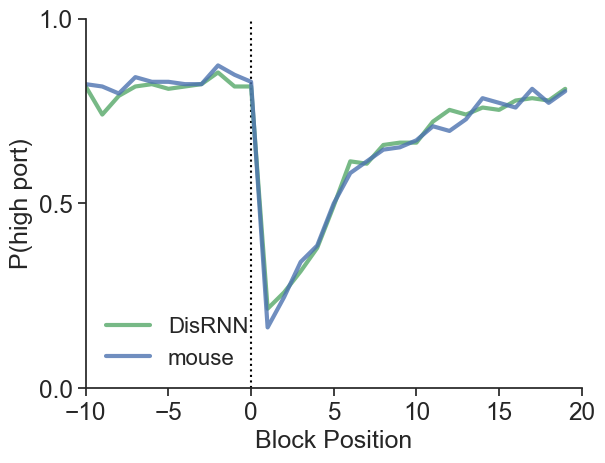

In [35]:
blocks_sim = switch_utils.blocker(df_va, y_sampled[:-1], ds_va._xs[1:,:,0]!=-1, 10, 20)
blocks = switch_utils.blocker(df_va, ds_va._xs[1:,:,0], ds_va._xs[1:,:,0]!=-1, 10, 20)
block_pos = np.arange(-10,20)
blocks_sim_high = blocks_sim[:,:,:,0] == blocks_sim[:,:,:,1]
blocks_high = blocks[:,:,:,0] == blocks[:,:,:,1]

sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 

fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.vlines(x=0,ymin=0,ymax=1.05,linestyle='dotted',color='black')
    
ax1.plot(block_pos, np.mean(blocks_sim_high[:,:,2], axis=1),label='DisRNN', alpha=0.8, linewidth=3, color=sns.color_palette()[2])
ax1.plot(block_pos, np.mean(blocks_high[:,:,2], axis=1),label='mouse', alpha=0.8, linewidth=3, color=sns.color_palette()[0])

ax1.set_yticks([0,0.5, 1.0])
ax1.legend(fontsize=16,frameon=False)
ax1.set(xlim=(-10,20), ylim=(0,1), xlabel='Block Position', ylabel='P(high port)')

print(np.mean(blocks_sim_high[:,:,2], axis=1))
print(np.mean(blocks_high[:,:,2], axis=1))
print(block_pos)


sns.despine()

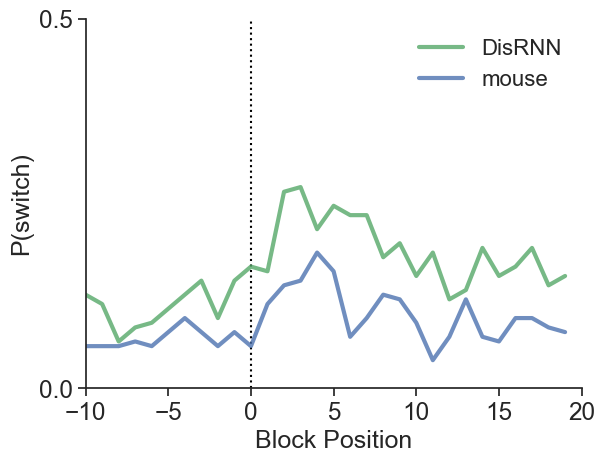

In [8]:
blocks_sim = switch_utils.blocker(df_va, y_sampled[:-1], ds_va._xs[1:,:,0]!=-1, 10, 21)
blocks = switch_utils.blocker(df_va, ds_va._xs[1:,:,0], ds_va._xs[1:,:,0]!=-1, 10, 21)
block_pos = np.arange(-10,20)
blocks_sim_high = blocks_sim[1:,:,:,0] != blocks_sim[:-1,:,:,0]
blocks_high = blocks[1:,:,:,0] != blocks[:-1,:,:,0]

sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 

fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.vlines(x=0,ymin=0,ymax=1.05,linestyle='dotted',color='black')
    
ax1.plot(block_pos, np.mean(blocks_sim_high[:,:,2], axis=1),label='DisRNN', alpha=0.8, linewidth=3, color=sns.color_palette()[2])
ax1.plot(block_pos, np.mean(blocks_high[:,:,2], axis=1),label='mouse', alpha=0.8, linewidth=3, color=sns.color_palette()[0])

ax1.set_yticks([0,0.5, 1.0])
ax1.legend(fontsize=16,frameon=False)
ax1.set(xlim=(-10,20), ylim=(0,0.5), xlabel='Block Position', ylabel='P(switch)')

sns.despine()